# Importing Libraries and making SparkSession

In [1]:
#Importing Libraries
import re
import json, requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from nltk.corpus import stopwords
from wordcloud import WordCloud

from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, DoubleType, LongType, ArrayType, FloatType

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

#Creating Spark Session
cluster_connect = "hdfs://master.data7201.emr:8020"
spark = SparkSession.builder.appName("DAS_Assignment") \
        .config("spark.hadoop.fs.defaultFS", cluster_connect) \
        .config("spark.driver.maxResultSize", "12g").getOrCreate()

sc = spark.sparkContext

#Data Location
file_location = "/data/ProjectDatasetFacebook/"

23/05/22 02:27:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Reading the Data

In [2]:
# FBads-US-2022207-19_00_01
df = spark.read.option("mode", "DROPMALFORMED").json(f"{file_location}*")
df = df.withColumn("file_name", slice(split(element_at(split(input_file_name(), "/"), -1), "-"), -2, 2))

In [3]:
print("Shape of dataframe:-\nRows:", df.count(), "Columns:", len(df.columns))

Shape of dataframe:-
Rows: 99630846 Columns: 18


In [4]:
print("Data Schema:-")
df.printSchema()

Data Schema:-
root
 |-- ad_creation_time: string (nullable = true)
 |-- ad_creative_body: string (nullable = true)
 |-- ad_creative_link_caption: string (nullable = true)
 |-- ad_creative_link_description: string (nullable = true)
 |-- ad_creative_link_title: string (nullable = true)
 |-- ad_delivery_start_time: string (nullable = true)
 |-- ad_delivery_stop_time: string (nullable = true)
 |-- ad_snapshot_url: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- demographic_distribution: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- age: string (nullable = true)
 |    |    |-- gender: string (nullable = true)
 |    |    |-- percentage: string (nullable = true)
 |-- funding_entity: string (nullable = true)
 |-- id: string (nullable = true)
 |-- impressions: struct (nullable = true)
 |    |-- lower_bound: string (nullable = true)
 |    |-- upper_bound: string (nullable = true)
 |-- page_id: string (nullable = true)
 |-- page_name:

# Preprocessing Data

#### Removing Nulls

In [5]:
#Percentage of Nulls in each column
null_percent = df.select([(count(when(col(i).isNull(), i))/count(lit(1))*100).alias(i) for i in df.columns]).collect()[0]
print("Percentage of Nulls:-")
null_percent

Percentage of Nulls:-


Row(ad_creation_time=0.0, ad_creative_body=1.5575828795030005, ad_creative_link_caption=10.603125863249218, ad_creative_link_description=25.25189337446758, ad_creative_link_title=9.936906487775884, ad_delivery_start_time=0.0, ad_delivery_stop_time=76.09849865171275, ad_snapshot_url=0.0, currency=0.0, demographic_distribution=4.042244105806348, funding_entity=0.17347338393573414, id=0.0, impressions=0.0, page_id=0.0, page_name=0.00030111156538809275, region_distribution=4.041908868263549, spend=0.0, file_name=0.0)

In [6]:
#Dropping Columns with high percentage of Nulls
drop_column_list = []
for key, value in null_percent.asDict().items():
    if(value >= 50):
        drop_column_list.append(key)

df = df.drop(*drop_column_list)

#### Removing Duplicate Rows

In [7]:
#Dropping duplicate Rows
df = df.dropDuplicates()

## Feature Engineering

In [8]:
#Making columns from other columns
df = df.withColumn("spend_lower_bound", col("spend.lower_bound")) \
    .withColumn("spend_upper_bound", col("spend.upper_bound")) \
    .withColumn("spend", concat(lit("("), col("spend_lower_bound"), lit(","), col("spend_upper_bound"), lit(")")))

df = df.withColumn("impressions_lower_bound", col("impressions.lower_bound")) \
    .withColumn("impressions_upper_bound", col("impressions.upper_bound")) \
    .withColumn("impressions", concat(lit("("), col("impressions_lower_bound"), lit(","), col("impressions_upper_bound"), lit(")")))

##### Making Currencies Standard

In [9]:
unique_currencies = df.select("currency").distinct().rdd.flatMap(lambda x: x).collect()
unique_currencies = ",".join(unique_currencies)

url = f"https://api.apilayer.com/exchangerates_data/latest?symbols={unique_currencies}&base=USD"
headers= {"apikey": "xjv1tmVhgcNmbq4ZbiKtZ82qvQf6OgFF"}

response = requests.request("GET", url, headers = headers)
value_rates = json.loads(response.text)["rates"]

#Modifying the spend amount column
for currency, rate in value_rates.items():
    df = df.withColumn("spend_upper_bound", when(col("currency") == currency, (col("spend_upper_bound") / rate).cast(IntegerType()))
                             .otherwise(col("spend_upper_bound")))
    df = df.withColumn("spend_lower_bound", when(col("currency") == currency, (col("spend_lower_bound") / rate).cast(IntegerType()))
                             .otherwise(col("spend_lower_bound")))

##### Record File Time

In [10]:
df = df.withColumn("datestring", element_at(col("file_name"), 1) )
df = df.withColumn("datestring", when(length(df["datestring"]) == 7, 
                    concat_ws("0", substring(df["datestring"], 1, 4), substring(df["datestring"], -3, 3) ))
                   .otherwise(df["datestring"]))
df = df.withColumn("timestring", element_at(col("file_name"), -1))

df = df.withColumn("file_date", concat_ws("_", col("datestring"), col("timestring")) )
df = df.withColumn("file_date", to_timestamp( col("file_date"), "yyyyMMdd_HH_mm_ss") )

drop_columns = ["file_name", "datestring", "timestring"]
df = df.drop(*drop_columns)

##### Changing DataTypes

In [11]:
df = df.withColumn("spend_lower_bound", df["spend_lower_bound"].cast(IntegerType())) \
    .withColumn("spend_upper_bound", df["spend_upper_bound"].cast(IntegerType())) \
    .withColumn("spend_average", expr("(spend_lower_bound + spend_upper_bound) / 2").cast("integer"))

df = df.withColumn("impressions_lower_bound", df["impressions_lower_bound"].cast(IntegerType())) \
    .withColumn("impressions_upper_bound", df["impressions_upper_bound"].cast(IntegerType())) \
    .withColumn("impressions_average", expr("(impressions_lower_bound + impressions_upper_bound) / 2").cast("integer"))

In [12]:
df = df.withColumn("ad_creation_time", df["ad_creation_time"].cast(DateType())) \
    .withColumn("ad_delivery_start_time", df["ad_delivery_start_time"].cast(DateType())) \
    .withColumn("currency", df["currency"].cast(StringType())) \
    .withColumn("impressions", df["impressions"].cast(StringType())) \
    .withColumn("spend", df["spend"].cast(StringType()))

# Making DataFrame for Visualisation

In [13]:
visual_df = df.select(["ad_creation_time", "ad_creative_body", "ad_creative_link_caption", "ad_creative_link_description", 
                       "ad_creative_link_title", "ad_delivery_start_time", "ad_snapshot_url", "funding_entity", "currency", 
                       "page_id", "page_name", "id", "spend_lower_bound", "spend_upper_bound", "spend_average", 
                       "impressions_average"])

In [14]:
visual_df = visual_df.groupBy(["ad_creation_time", "ad_creative_body", "ad_creative_link_caption",
                               "ad_creative_link_description", "ad_creative_link_title", "ad_delivery_start_time", 
                               "ad_snapshot_url", "funding_entity", "currency", "page_id", "page_name", "id"]).agg(
                                                avg("spend_lower_bound").alias("spend_lower_bound"), 
                                                avg("spend_upper_bound").alias("spend_upper_bound"), 
                                                avg("spend_average").alias("spend_average"), 
                                                sum("impressions_average").alias("impressions_average"))

visual_df = visual_df.orderBy("id")

In [15]:
print("Shape of dataframe:-\nRows:", visual_df.count(), "Columns:", len(visual_df.columns))

Shape of dataframe:-
Rows: 5730987 Columns: 16


### Spark-SQL Analysis

In [16]:
visual_df.createOrReplaceTempView("visual_sql")

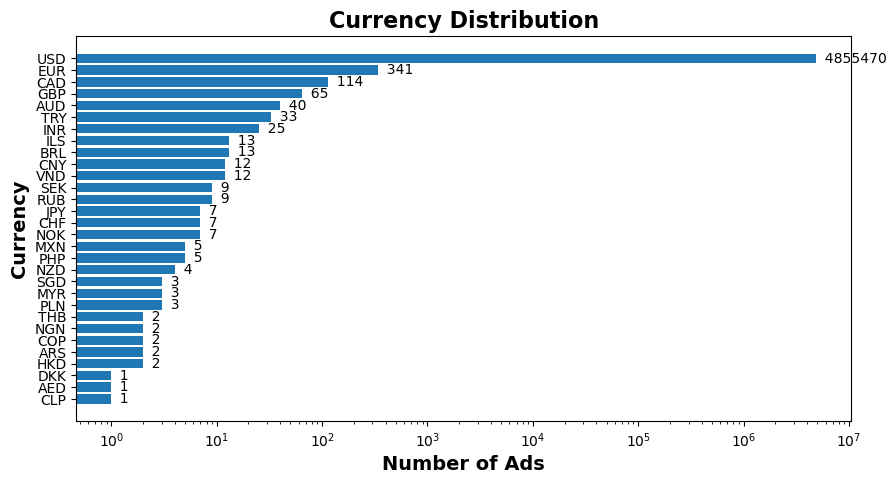

In [17]:
#Distribution of Currency Payments
currency_count = spark.sql("SELECT currency, count(Distinct id) AS count FROM visual_sql GROUP BY currency ORDER BY count").toPandas()

plt.figure(figsize=(10, 5))
plt.barh(currency_count["currency"], currency_count["count"])
for i, count in enumerate(currency_count["count"]):
    plt.text(count, i, "  "+str(count), ha='left', va='center')

plt.title("Currency Distribution", fontsize = 16, fontweight = "bold")
plt.xlabel("Number of Ads", fontsize = 14, fontweight = "bold")
plt.xscale('log')
plt.ylabel("Currency", fontsize = 14, fontweight = "bold")
plt.show()

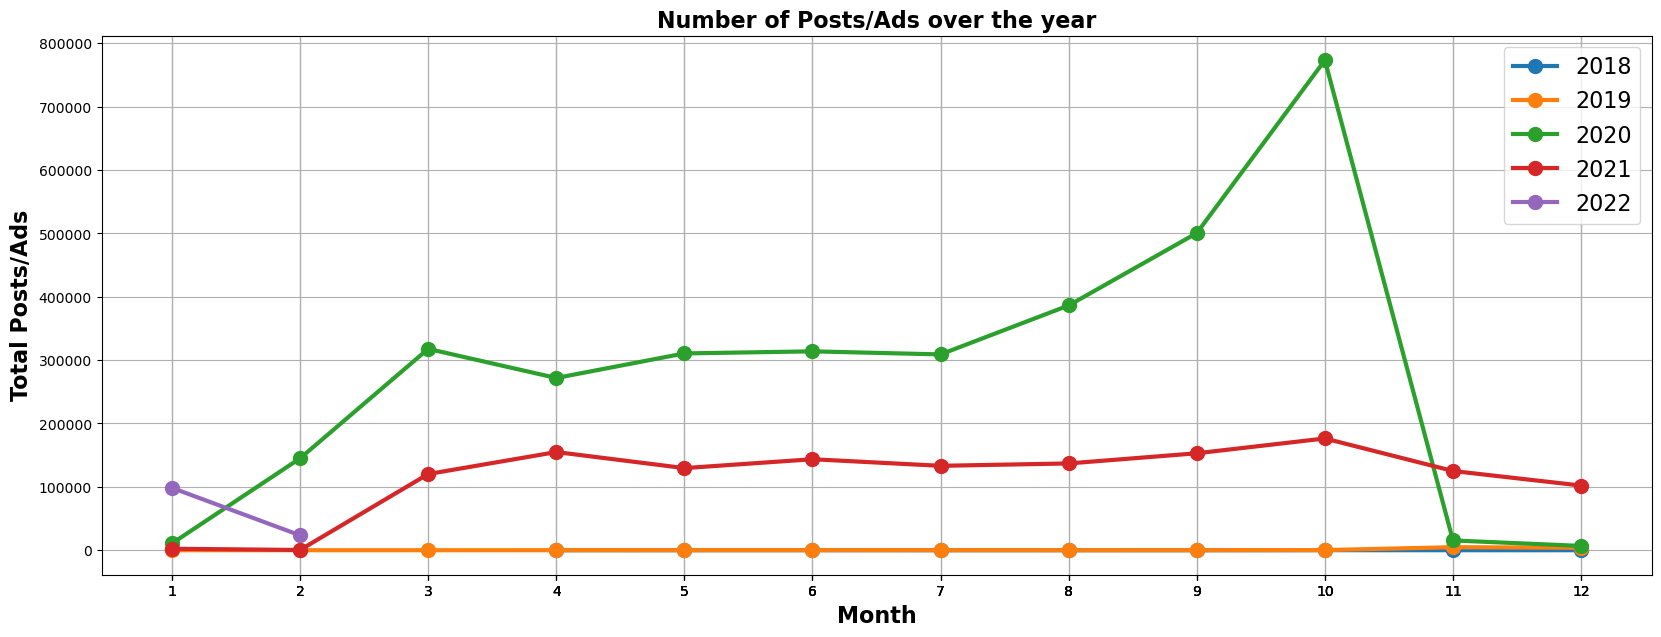

In [18]:
df.createOrReplaceTempView("df_sql")
ad_year = spark.sql("SELECT YEAR(ad_delivery_start_time) AS year, MONTH(ad_delivery_start_time) AS month, COUNT(DISTINCT id) AS `Posts/Ads` FROM df_sql GROUP BY YEAR(ad_delivery_start_time), MONTH(ad_delivery_start_time) ORDER BY year, month").toPandas()

plt.figure(figsize=(20, 7))

for i in sorted(ad_year["year"].unique()):
    plt.plot(ad_year[ad_year["year"] == i]["month"], ad_year[ad_year["year"] == i]["Posts/Ads"], linewidth = 3, marker = "o", markersize = 10)
    
plt.title("Number of Posts/Ads over the year", fontsize = 16, fontweight = "bold")
plt.xlabel("Month", fontsize = 16, fontweight = "bold")
plt.xticks(ad_year["month"])
plt.ylabel("Total Posts/Ads", fontsize = 16, fontweight = "bold")
plt.ticklabel_format(style = "plain", axis = "y", useOffset = False)
plt.legend(sorted(ad_year["year"].unique()), fontsize = 16)
plt.grid(True)
plt.show()

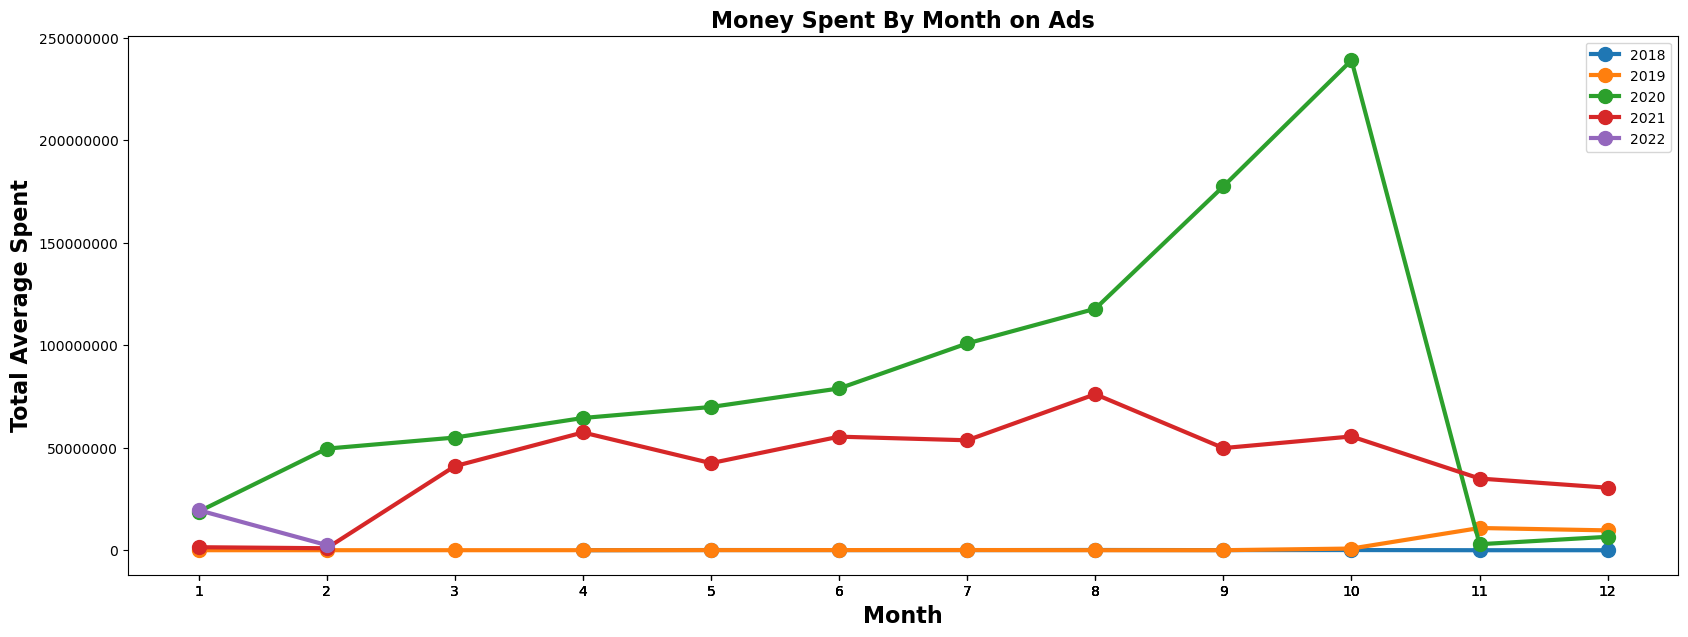

In [19]:
#Money Spent Month Wise Yearly
spend_by_time = spark.sql("SELECT YEAR(ad_delivery_start_time) AS year, MONTH(ad_delivery_start_time) AS month, SUM(spend_average) AS average_sum FROM visual_sql GROUP BY YEAR(ad_delivery_start_time), MONTH(ad_delivery_start_time) ORDER BY year, month").toPandas()

plt.figure(figsize=(20, 7))

for i in sorted(spend_by_time["year"].unique()):
    plt.plot(spend_by_time[spend_by_time["year"] == i]["month"], spend_by_time[spend_by_time["year"] == i]["average_sum"], linewidth = 3, marker = "o", markersize = 10)
    
plt.title("Money Spent By Month on Ads", fontsize = 16, fontweight = "bold")
plt.xlabel("Month", fontsize = 16, fontweight = "bold")
plt.xticks(spend_by_time["month"])
plt.ylabel("Total Average Spent", fontsize = 16, fontweight = "bold")
plt.ticklabel_format(style = "plain", axis = "y", useOffset = False)
plt.legend(sorted(spend_by_time["year"].unique()))
plt.show()

In [20]:
#Money Spent by individual Pages on Impressions
df.createOrReplaceTempView("df_sql")
ad_spend = spark.sql("""
    SELECT page_name, sum(average_spend) AS Spend, sum(average_impressions) AS Impressions
    FROM (
        SELECT page_name, id, avg(spend_average) AS average_spend, SUM(impressions_average) AS average_impressions
        FROM df_sql
        GROUP BY page_name, id
    )
    GROUP BY page_name
    ORDER BY Spend DESC, Impressions DESC
""").toPandas()
ad_spend = ad_spend.reset_index(drop=True)
ad_spend.index = ad_spend.index + 1
print("Top 10 Pages with highest spend & Impressions")
ad_spend.head(10)

Top 10 Pages with highest spend & Impressions


,page_name,Spend,Impressions
1,Joe Biden,56373995.29,20750387463.00
2,Donald J. Trump,43236320.52,19055897209.00
3,Facebook,17952048.10,14329629955.00
4,Stop Republicans,15721979.21,8429744105.00
5,Facebook App,12572944.04,466047454.00
6,U.S. Census Bureau,12116902.53,19613193526.00
7,Mike Bloomberg,10172765.52,960690161.00
8,Lower My Bills,9323100.66,2795138748.00
9,GOP,8631390.48,3219643207.00
10,Instagram,8199982.48,246284447.00


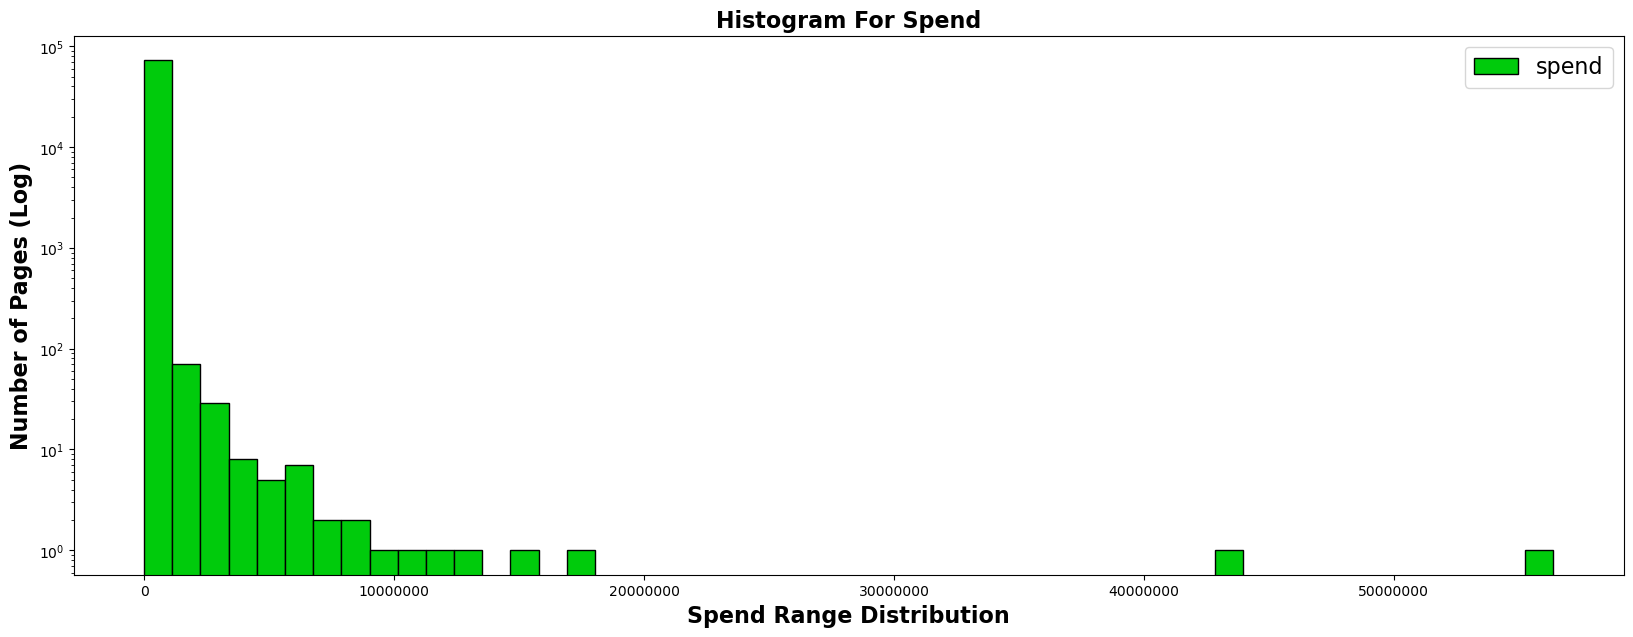

In [21]:
plt.figure(figsize=(20, 7))
plt.hist(ad_spend["Spend"], bins = 50, edgecolor = "black", log = True, label = "spend", color = "#00CB0C")
plt.title("Histogram For Spend", fontsize = 16, fontweight = "bold")
plt.xlabel("Spend Range Distribution", fontsize = 16, fontweight = "bold")
plt.ylabel("Number of Pages (Log)", fontsize = 16, fontweight = "bold")
plt.ticklabel_format(style = "plain", axis = "x", useOffset = False)
plt.legend(fontsize = 16)
plt.show()

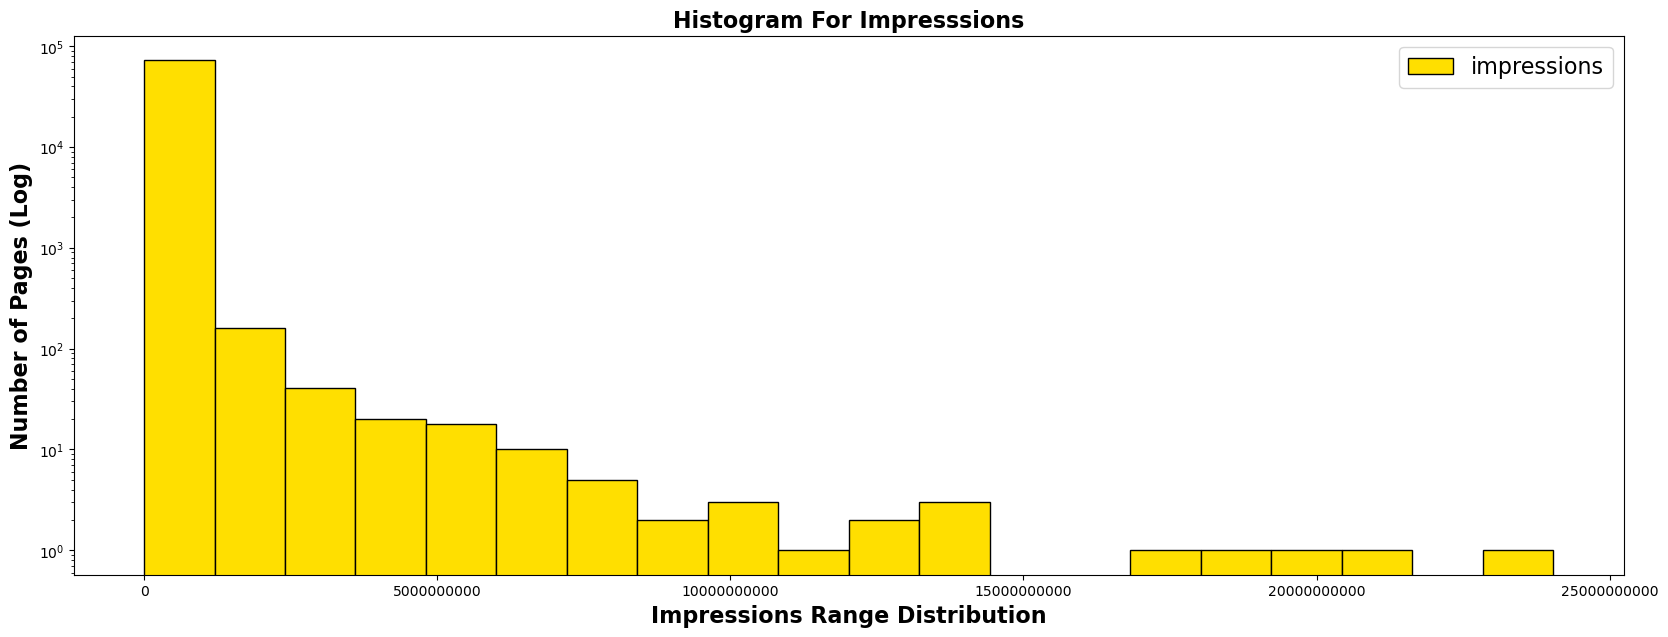

In [22]:
plt.figure(figsize=(20, 7))
plt.hist(ad_spend["Impressions"], bins = 20, edgecolor = "black", log = True, color = "#FFDF00", label = "impressions")
plt.title("Histogram For Impresssions", fontsize = 16, fontweight = "bold")
plt.xlabel("Impressions Range Distribution", fontsize = 16, fontweight = "bold")
plt.ylabel("Number of Pages (Log)", fontsize = 16, fontweight = "bold")
plt.ticklabel_format(style = "plain", axis = "x", useOffset = False)
plt.legend(fontsize = 16)
plt.show()

In [23]:
#Number of ads by Page
page_ads = spark.sql("SELECT page_name, count(DISTINCT id) AS `Number of Posts/Ads`  FROM visual_sql GROUP BY page_name ORDER BY `Number of Posts/Ads` DESC").toPandas()
page_ads = page_ads.reset_index(drop=True)
page_ads.index = page_ads.index + 1
print("Top 10 Pages with highest Number of funded Ads")
page_ads.head(10)

Top 10 Pages with highest Number of funded Ads


,page_name,Number of Posts/Ads
1,Donald J. Trump,307429
2,SmartNews,82731
3,Joe Biden,81876
4,GOP,60921
5,SmartNews - Local Breaking News,54938
6,Democratic Party,50083
7,Alexandria Ocasio-Cortez,48015
8,Mike Pence,44522
9,Team Trump,43988
10,MoveOn,41184


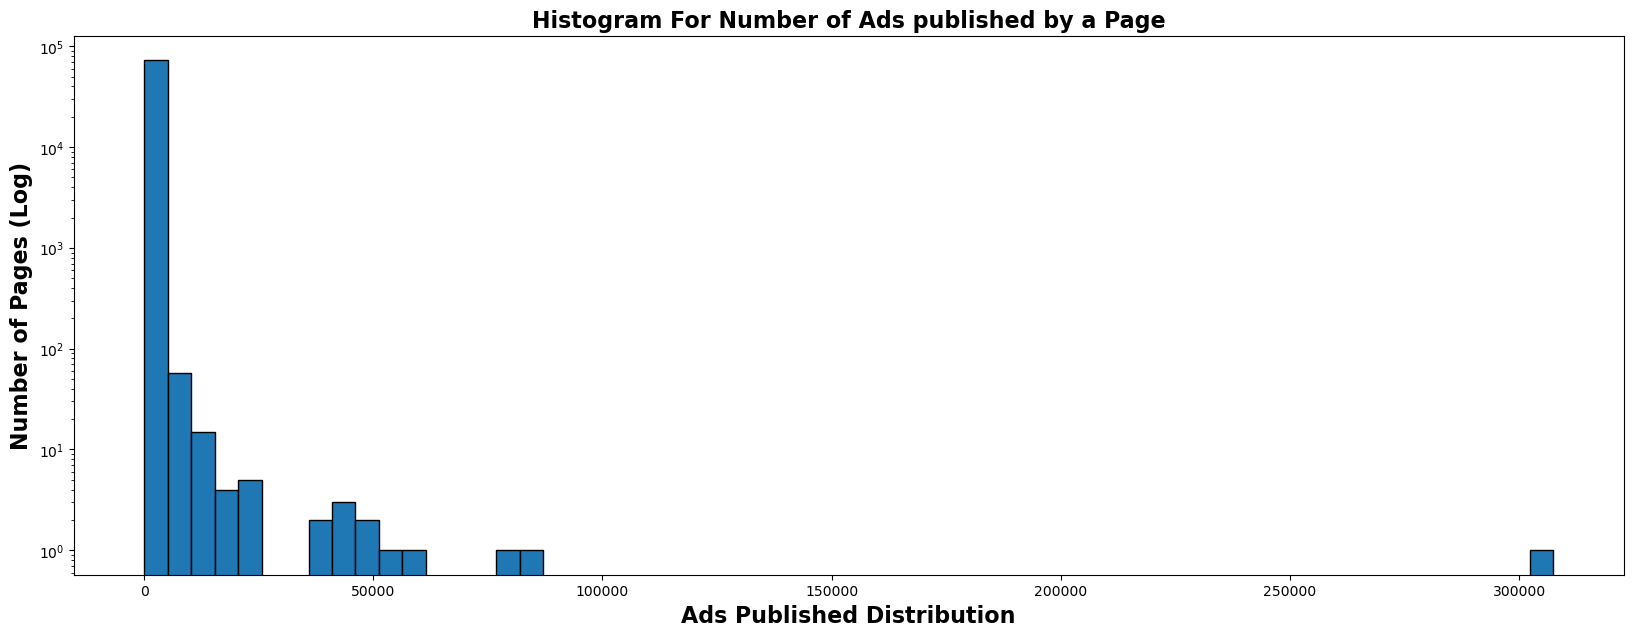

In [24]:
plt.figure(figsize=(20, 7))
plt.hist(page_ads["Number of Posts/Ads"], bins = 60, edgecolor = "black", log = True)
plt.title("Histogram For Number of Ads published by a Page", fontsize = 16, fontweight = "bold")
plt.xlabel("Ads Published Distribution", fontsize = 16, fontweight = "bold")
plt.ylabel("Number of Pages (Log)", fontsize = 16, fontweight = "bold")
plt.show()

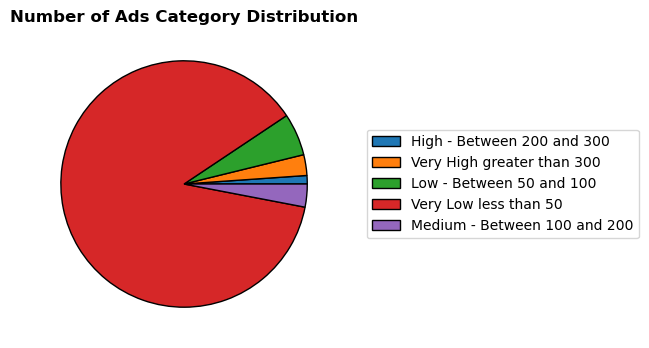

In [25]:
ad_number_category = spark.sql("""SELECT ad_count_group, count(*) AS count FROM (SELECT page_name, 
  CASE 
    WHEN ad_count > 300 THEN 'Very High'
    WHEN ad_count BETWEEN 200 AND 300 THEN 'High'
    WHEN ad_count BETWEEN 100 AND 200 THEN 'Medium'
    WHEN ad_count BETWEEN 50 AND 100 THEN 'Low'
    ELSE 'Very Low' 
  END AS ad_count_group
FROM (
  SELECT page_name, COUNT(DISTINCT id) AS ad_count 
  FROM visual_sql 
  GROUP BY page_name
)) GROUP BY ad_count_group""").toPandas()

plt.figure(figsize=(4,4))
plt.pie(ad_number_category["count"],  wedgeprops = {"edgecolor": "black", "linewidth": 1})
plt.title("Number of Ads Category Distribution", fontsize = 12, fontweight = "bold")
plt.legend(bbox_to_anchor = (2, 0.5), loc = "center right", labels = ["High - Between 200 and 300", "Very High greater than 300", "Low - Between 50 and 100", "Very Low less than 50", "Medium - Between 100 and 200"])
plt.show()

In [26]:
#Top 10 organisations with most funded ADs
org_funded_ads = spark.sql("SELECT funding_entity, count(DISTINCT id) AS number_of_ads FROM visual_sql GROUP BY funding_entity ORDER BY number_of_ads DESC").toPandas()
print("Top 10 Organisation with highest Number of funded Ads")
org_funded_ads.head(10)

Top 10 Organisation with highest Number of funded Ads


,funding_entity,number_of_ads
0,TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE,229575
1,"DONALD J. TRUMP FOR PRESIDENT, INC.",225544
2,"SmartNews International, Inc.",152011
3,REPUBLICAN NATIONAL COMMITTEE,90626
4,BIDEN VICTORY FUND,57062
5,DNC SERVICES CORP./DEM. NAT'L COMMITTEE,53234
6,Shield Republic,40459
7,Mike Bloomberg 2020 Inc,40293
8,BIDEN FOR PRESIDENT,38494
9,Alexandria Ocasio-Cortez for Congress,36914


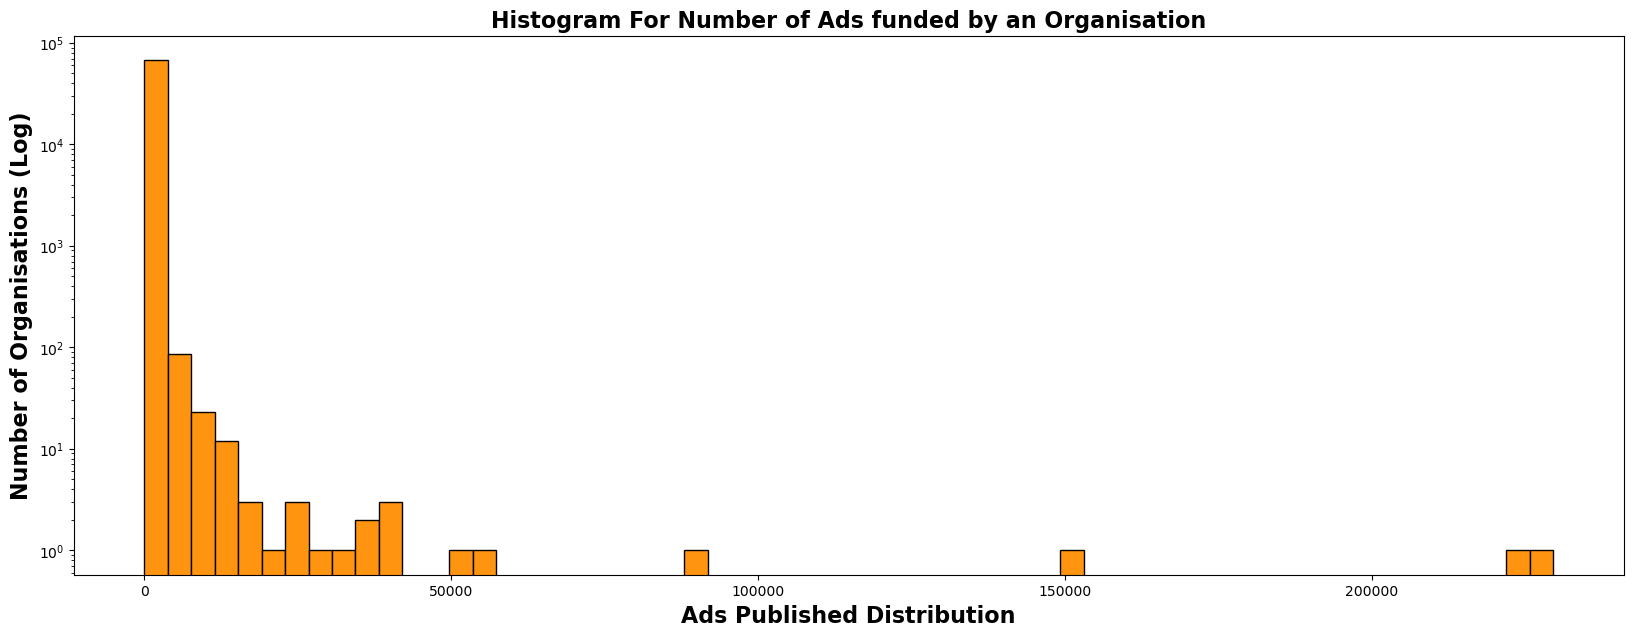

In [27]:
plt.figure(figsize=(20, 7))
plt.hist(org_funded_ads["number_of_ads"], bins = 60, edgecolor = "black", log = True, color = "#FF9411")
plt.title("Histogram For Number of Ads funded by an Organisation", fontsize = 16, fontweight = "bold")
plt.xlabel("Ads Published Distribution", fontsize = 16, fontweight = "bold")
plt.ylabel("Number of Organisations (Log)", fontsize = 16, fontweight = "bold")
plt.show()

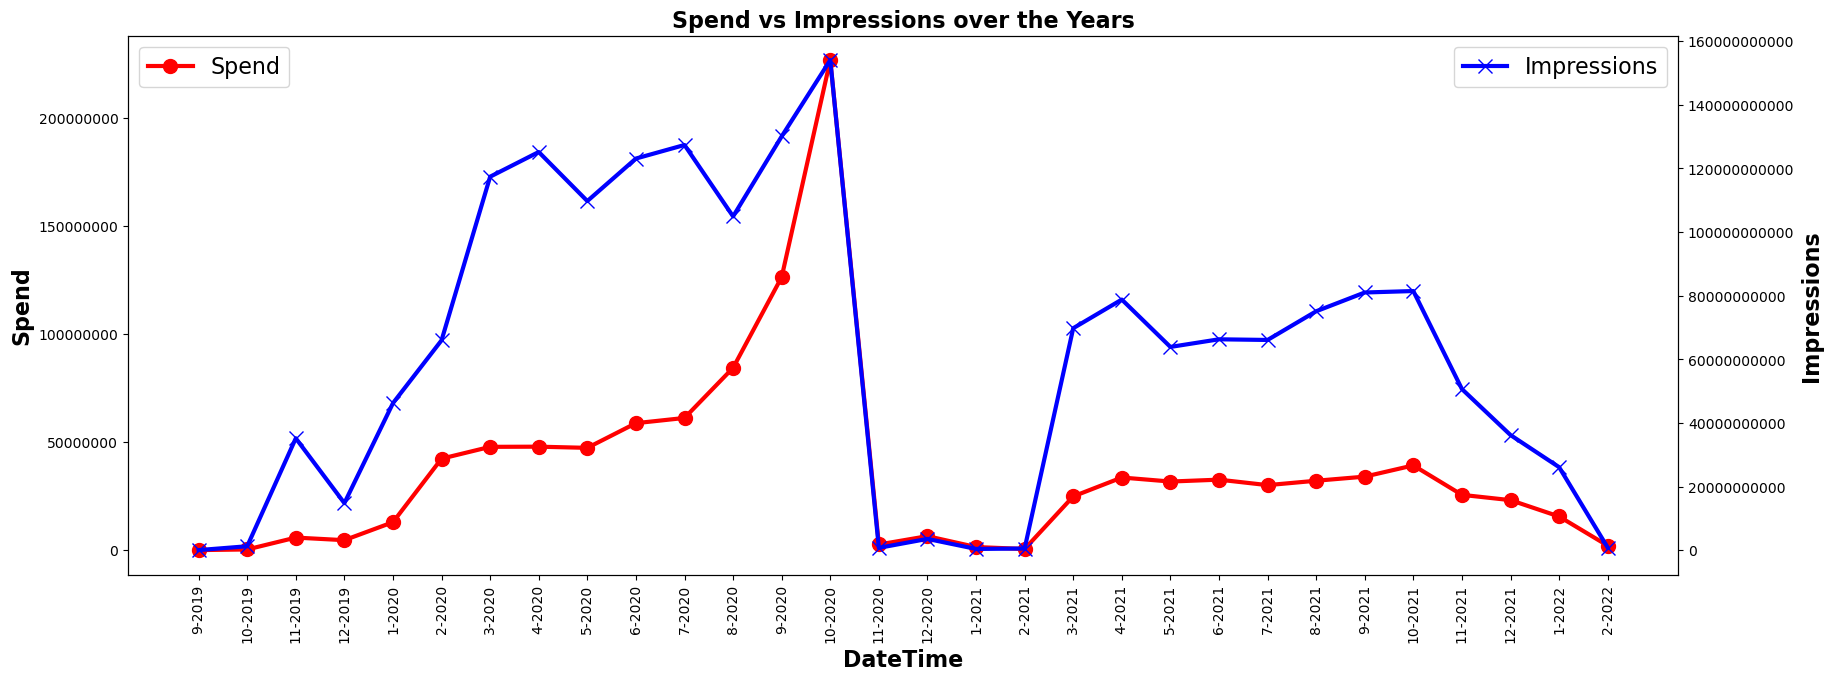

In [28]:
#Line chart for spend and impressions
line_spend_impressions = spark.sql("SELECT month(ad_delivery_start_time) AS month, year(ad_delivery_start_time) AS year, id, AVG(spend_average) AS Spend, SUM(impressions_average) AS Impressions FROM visual_sql GROUP BY month(ad_delivery_start_time), year(ad_delivery_start_time), id").toPandas()
line_spend_impressions = line_spend_impressions.groupby(["month", "year"], as_index = False).agg({"Spend": "sum", 'Impressions': "sum"})
line_spend_impressions = line_spend_impressions.sort_values(["year", "month"], ascending = True)
line_spend_impressions["Time"] = line_spend_impressions.apply(lambda x: str(int(x["month"])) + "-" + str(int(x["year"])), axis=1)
line_spend_impressions.reset_index(drop = True, inplace = True)
line_spend_impressions = line_spend_impressions[17:]

plt.figure(figsize=(20, 7))
plt.title("Spend vs Impressions over the Years", fontsize = 16, fontweight = "bold")

ax1 = plt.gca()
ax1.ticklabel_format(style = "plain", axis = "y")
ax1.plot(line_spend_impressions["Time"], line_spend_impressions["Spend"], label = "Spend", color = "r", linewidth = 3, marker = "o", markersize = 10)
ax1.set_xlabel("DateTime", fontsize = 16, fontweight = "bold")
ax1.set_ylabel("Spend", fontsize = 16, fontweight = "bold")
ax1.tick_params(axis = "x", rotation = 90)
ax1.legend(fontsize = 16, loc = "upper left")

ax2 = ax1.twinx()
ax2.ticklabel_format(style = "plain", axis = "y")
ax2.plot(line_spend_impressions["Time"], line_spend_impressions["Impressions"], label = "Impressions", color = "b", linewidth = 3, marker = "x", markersize = 10)
ax2.set_ylabel("Impressions", fontsize = 16, fontweight = "bold")
ax2.legend(fontsize = 16, loc = "upper right")

plt.show()

# Main Analysis

In [29]:
df.createOrReplaceTempView("df_sql")
spark.sql("SELECT page_name, count(DISTINCT id) AS ad_count FROM df_sql WHERE year(file_date) = 2020 GROUP BY page_name ORDER BY ad_count DESC LIMIT 10").toPandas()

,page_name,ad_count
0,Donald J. Trump,307429
1,SmartNews,82591
2,Joe Biden,80698
3,GOP,55404
4,SmartNews - Local Breaking News,54937
5,Mike Pence,44488
6,Team Trump,43406
7,Mike Bloomberg,40038
8,Shield Republic,32524
9,MoveOn,28370


In [30]:
main_df = df.filter((col("page_name").isin(["Donald J. Trump", "Joe Biden"])) & (year(col("file_date")) == 2020))
main_df.createOrReplaceTempView("main_sql")

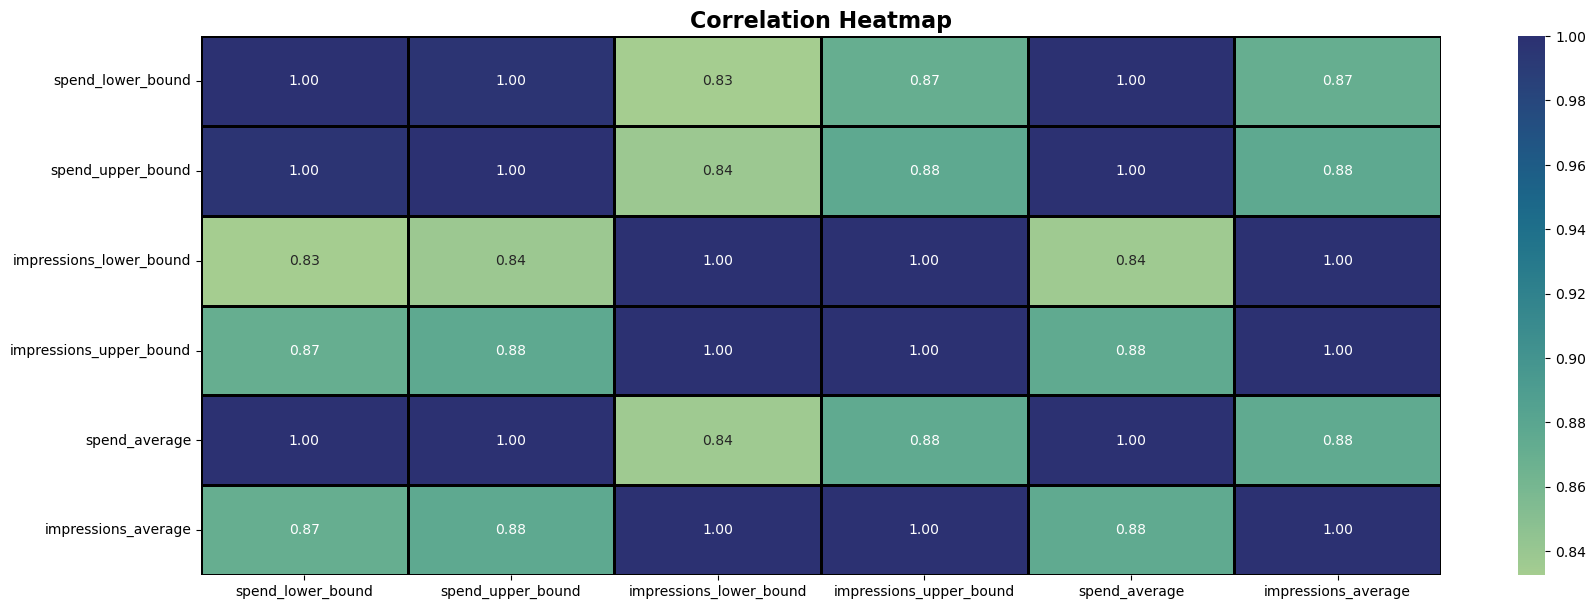

In [31]:
corr_df = main_df.filter(month(col("file_date")) == 11).toPandas().corr()
plt.figure(figsize = (20, 7))
sns.heatmap(corr_df, annot = True, cmap = "crest", linewidth = 1, linecolor = "black", fmt = ".2f")
plt.title("Correlation Heatmap", fontsize = 16, fontweight = "bold")
plt.show()

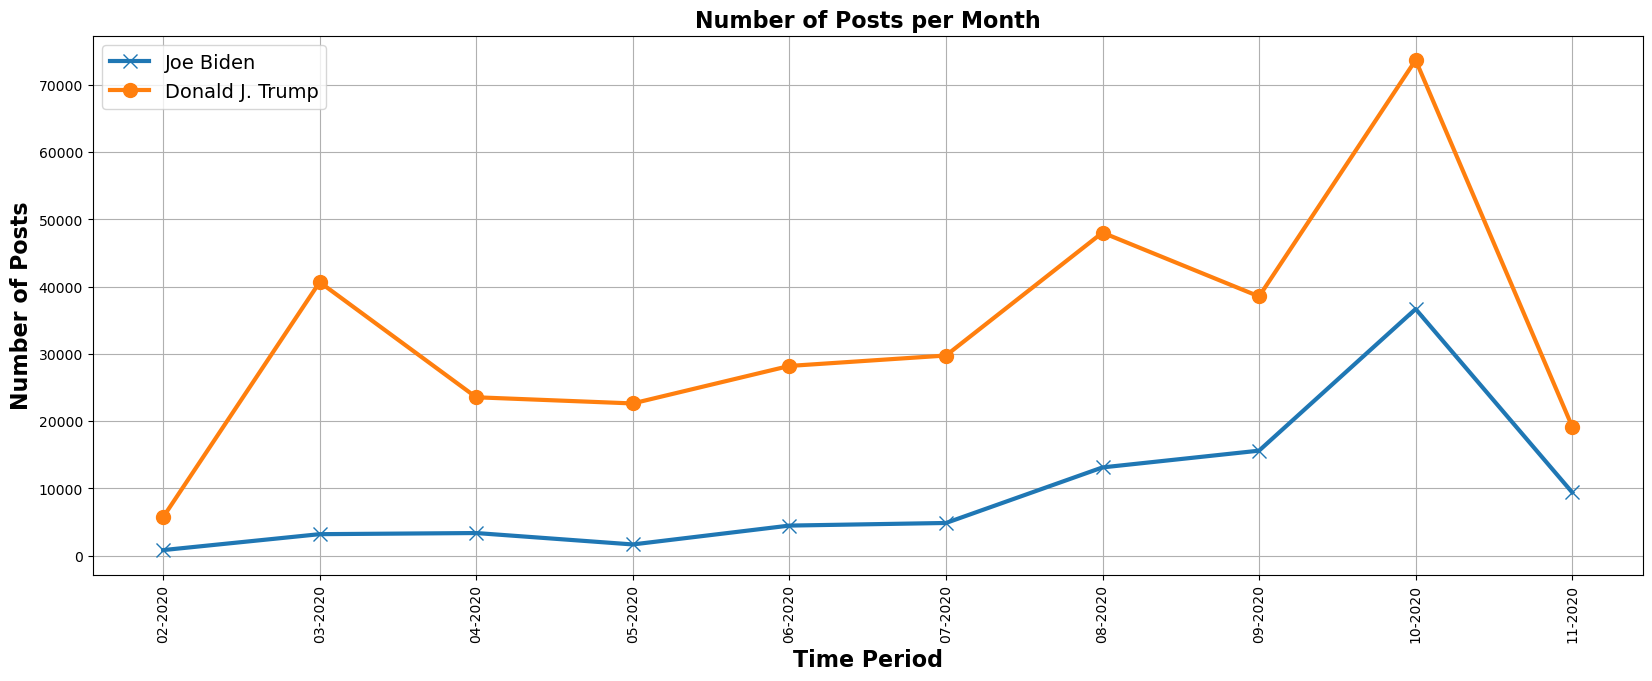

In [32]:
number_ads_df = spark.sql("SELECT page_name, DATE_FORMAT(file_date, 'MM-yyyy') AS date, count(DISTINCT id) AS count FROM main_sql GROUP BY page_name, DATE_FORMAT(file_date, 'MM-yyyy') ORDER BY DATE_FORMAT(file_date, 'MM-yyyy')").toPandas()

plt.figure(figsize=(20, 7))

plt.plot(number_ads_df[number_ads_df["page_name"] == "Joe Biden"]["date"], number_ads_df[number_ads_df["page_name"] == "Joe Biden"]["count"], label = "Joe Biden", linewidth = 3, marker = "x", markersize = 10)
plt.plot(number_ads_df[number_ads_df["page_name"] == "Donald J. Trump"]["date"], number_ads_df[number_ads_df["page_name"] == "Donald J. Trump"]["count"], label = "Donald J. Trump", linewidth = 3, marker = "o", markersize = 10)

plt.title("Number of Posts per Month", fontsize = 16, fontweight = "bold")
plt.xlabel("Time Period", fontsize = 16, fontweight = "bold")
plt.ylabel("Number of Posts", fontsize = 16, fontweight = "bold")
plt.xticks(rotation = 90)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

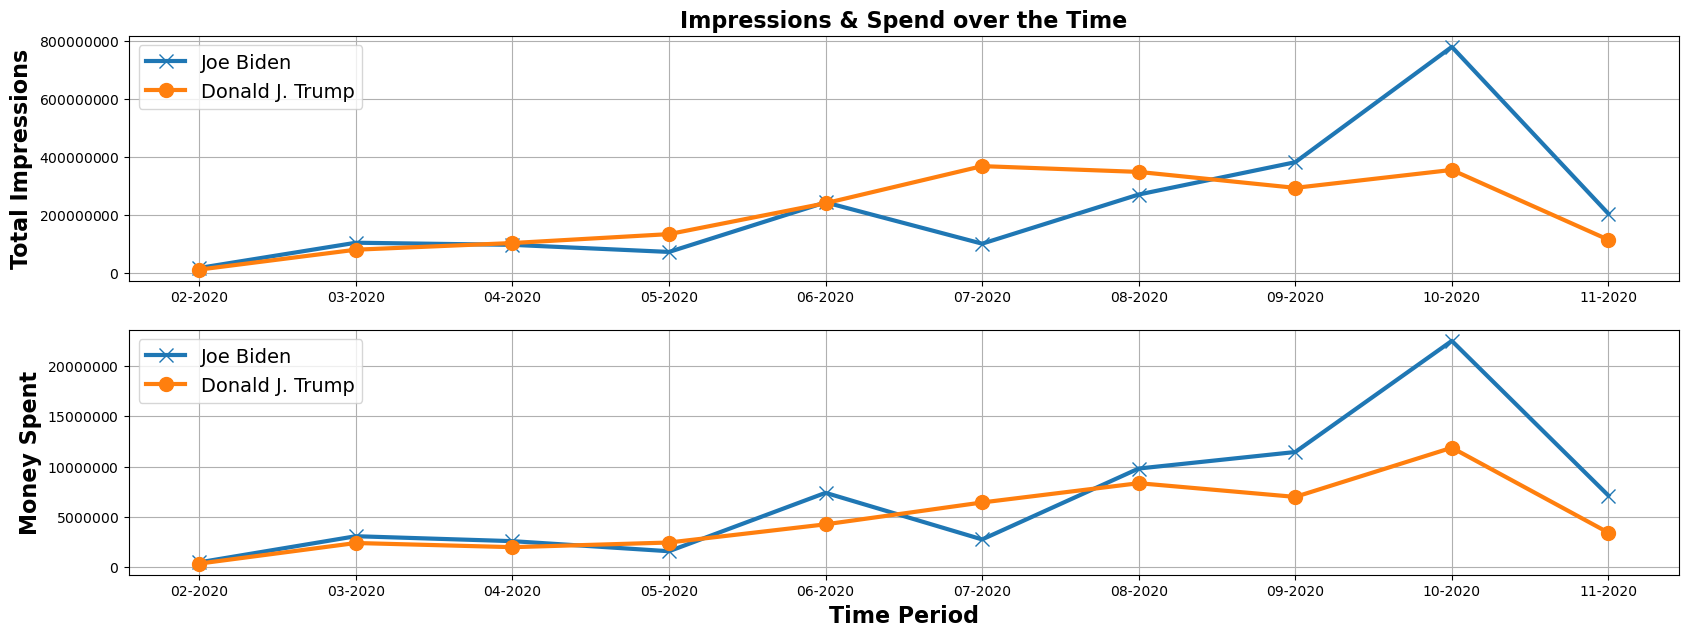

In [33]:
ad_impression_spend_df = spark.sql("SELECT page_name, date, sum(money_spent) AS money_spent, sum(total_impressions) AS total_impressions FROM (SELECT page_name, DATE_FORMAT(file_date, 'MM-yyyy') AS date, id, avg(spend_average) AS money_spent, avg(impressions_average) AS total_impressions FROM main_sql GROUP BY page_name, DATE_FORMAT(file_date, 'MM-yyyy'), id) GROUP BY page_name, date ORDER BY date").toPandas()

plt.figure(figsize=(20, 7))
plt.subplot(2, 1, 1)
plt.plot(ad_impression_spend_df[ad_impression_spend_df["page_name"] == "Joe Biden"]["date"], ad_impression_spend_df[ad_impression_spend_df["page_name"] == "Joe Biden"]["total_impressions"], label = "Joe Biden", linewidth = 3, marker = "x", markersize = 10)
plt.plot(ad_impression_spend_df[ad_impression_spend_df["page_name"] == "Donald J. Trump"]["date"], ad_impression_spend_df[ad_impression_spend_df["page_name"] == "Donald J. Trump"]["total_impressions"], label = "Donald J. Trump", linewidth = 3, marker = "o", markersize = 10)
plt.ylabel("Total Impressions", fontsize = 16, fontweight = "bold")
plt.title("Impressions & Spend over the Time", fontsize = 16, fontweight = "bold")
plt.ticklabel_format(style = "plain", axis = "y", scilimits = (0,0), useMathText = True)
plt.legend(fontsize = 14)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(ad_impression_spend_df[ad_impression_spend_df["page_name"] == "Joe Biden"]["date"], ad_impression_spend_df[ad_impression_spend_df["page_name"] == "Joe Biden"]["money_spent"], label = "Joe Biden", linewidth = 3, marker = "x", markersize = 10)
plt.plot(ad_impression_spend_df[ad_impression_spend_df["page_name"] == "Donald J. Trump"]["date"], ad_impression_spend_df[ad_impression_spend_df["page_name"] == "Donald J. Trump"]["money_spent"], label = "Donald J. Trump", linewidth = 3, marker = "o", markersize = 10)
plt.xlabel("Time Period", fontsize = 16, fontweight = "bold")
plt.ylabel("Money Spent", fontsize = 16, fontweight = "bold")
plt.ticklabel_format(style = "plain", axis = "y", scilimits = (0,0), useMathText = True)
plt.legend(fontsize = 14)
plt.grid(True)

plt.show()

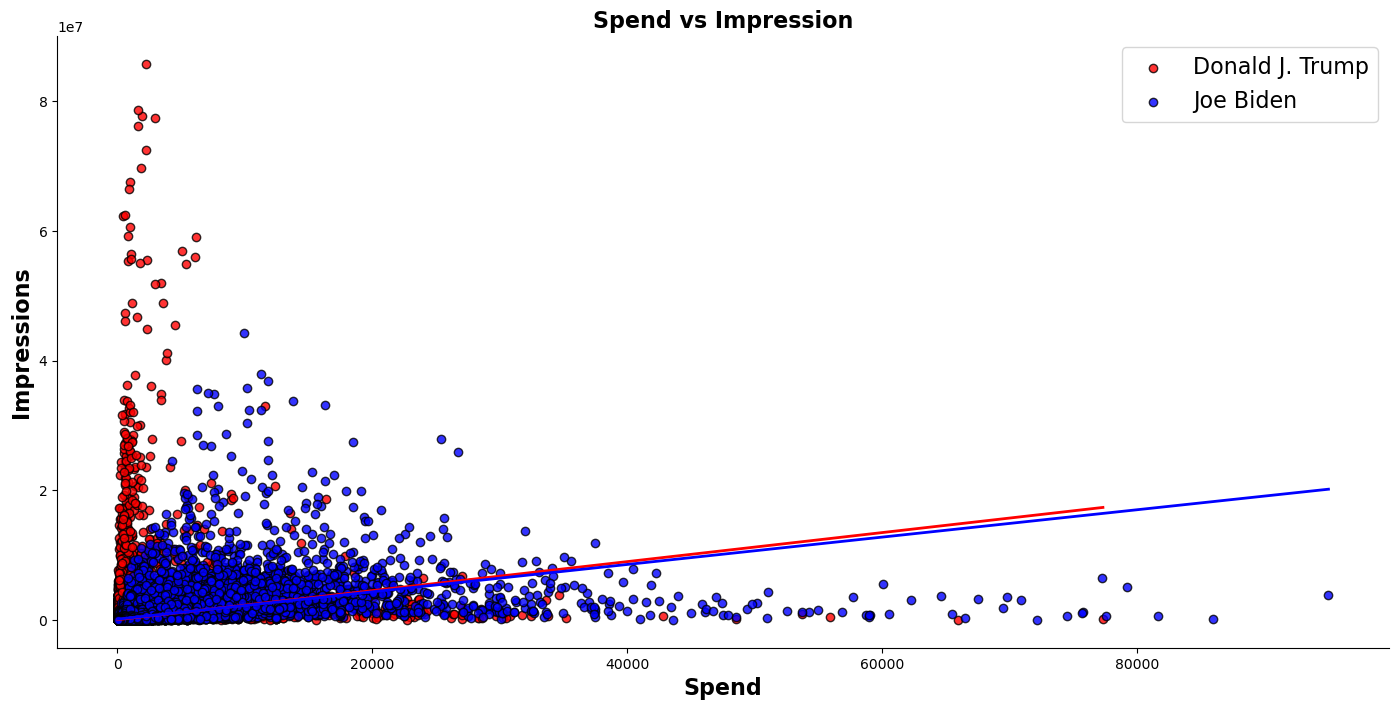

In [34]:
scatter_df = spark.sql("""SELECT page_name, id, avg(spend_average) AS spend, sum(impressions_average) AS impressions FROM main_sql 
GROUP BY page_name, id HAVING avg(spend_average) < 100000""").toPandas()

scatter_plot = sns.lmplot(x = "spend", y = "impressions", hue = "page_name", data = scatter_df, palette = ["red", "blue"], 
                          ci = None, line_kws={"linewidth": 2}, scatter_kws={"edgecolor": "black"}, height = 7, aspect = 2, 
                          legend = False)

plt.title("Spend vs Impression", fontsize = 16, fontweight = "bold")
plt.xlabel("Spend", fontsize = 16, fontweight = "bold")
plt.ylabel("Impressions", fontsize = 16, fontweight = "bold")
plt.legend(fontsize = 16)
plt.show()

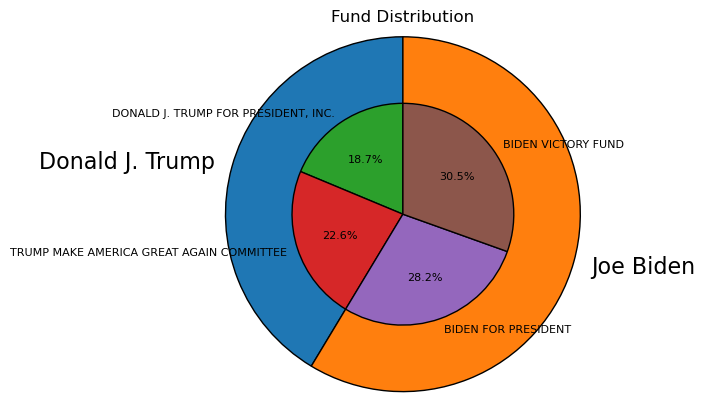

In [35]:
entity_df = spark.sql("""SELECT page_name, funding_entity, sum(spend) AS spend FROM (SELECT page_name, funding_entity, 
year(file_date) AS year, month(file_date) AS month, id, avg(spend_average) AS spend FROM main_sql 
WHERE page_name IN ('Donald J. Trump', 'Joe Biden') GROUP BY page_name, funding_entity, year(file_date), month(file_date), id) 
GROUP BY page_name, funding_entity, year, month ORDER BY spend desc""").toPandas()

entity_df = entity_df.groupby(["page_name", "funding_entity"], as_index = False).sum("spend").sort_values(by = ["page_name", "spend"])
candidate_df = entity_df.groupby(["page_name"], as_index = False).sum("spend").sort_values(by = ["page_name", "spend"])

sizes_outer = candidate_df["spend"]
labels_outer = candidate_df["page_name"]

sizes_inner = entity_df["spend"]
labels_inner = entity_df["funding_entity"]

fig, ax = plt.subplots()
outer_pie, _ = ax.pie(sizes_outer, labels=labels_outer, radius=1.2, startangle=90, textprops={"fontsize": 16})
inner_pie, inner_labels, _ = ax.pie(sizes_inner, labels=labels_inner, radius=0.75, startangle=90, textprops={"fontsize": 8}, autopct='%1.1f%%')

plt.setp(inner_pie, edgecolor="#000000")
plt.setp(outer_pie, edgecolor="#000000")

ax.set_aspect("equal")
plt.title("Fund Distribution")
plt.show()

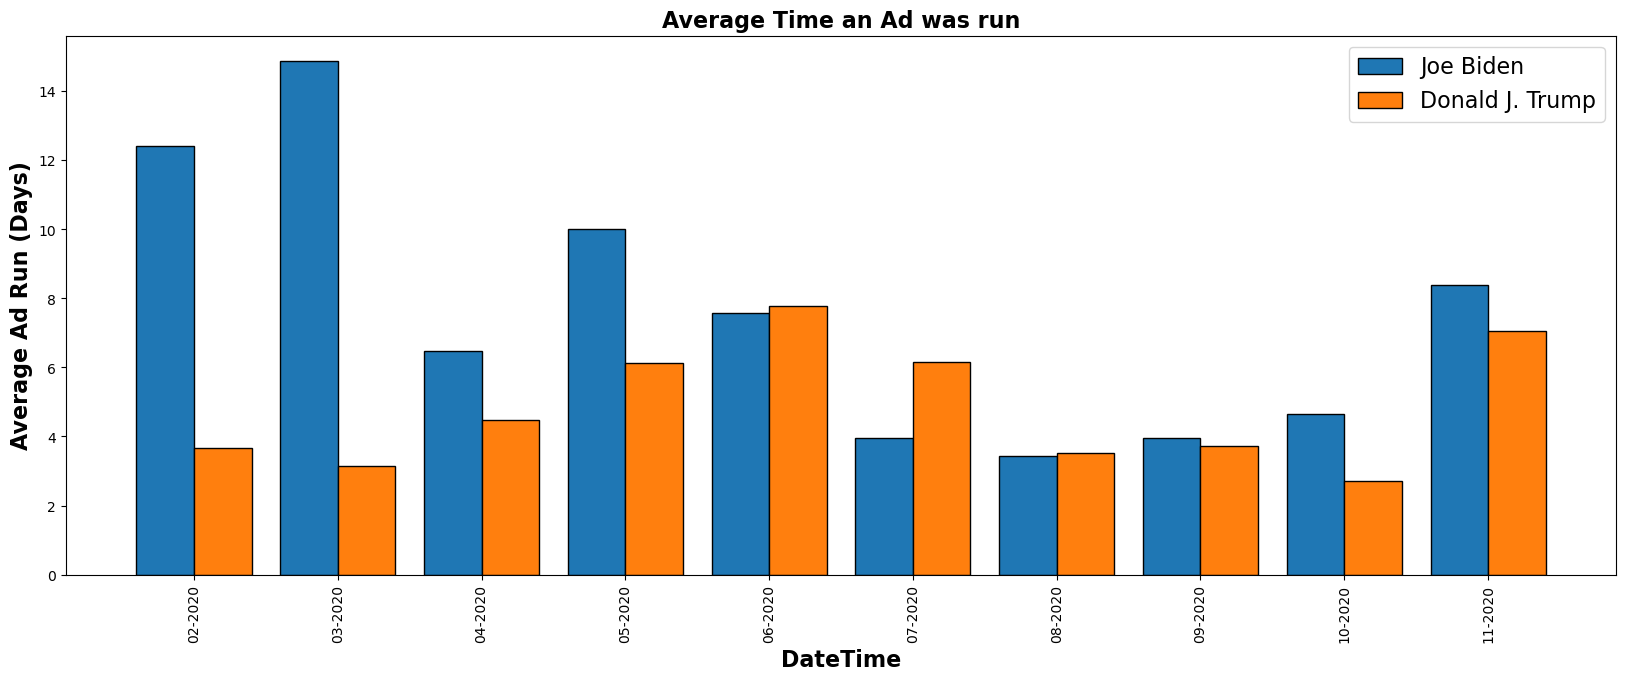

In [36]:
ad_time_df = spark.sql("""SELECT page_name, month_year, AVG(TimeRun) AS ad_time_run FROM (
SELECT page_name, DATE_FORMAT(file_date, 'MM-yyyy') AS month_year, id, DATEDIFF(day, min(ad_creation_time), max(file_date)) AS TimeRun 
FROM main_sql WHERE page_name IN ('Joe Biden', 'Donald J. Trump') and year(file_date) = 2020 
GROUP BY page_name, DATE_FORMAT(file_date, 'MM-yyyy'), id) GROUP BY page_name, month_year""").toPandas()


ad_time_df = ad_time_df.sort_values(["month_year"])
ad_time_df["month_year"] = ad_time_df["month_year"].astype(str)

plt.figure(figsize=(20,7))
bar_width = 0.40
bar_positions1 = np.arange(len( ad_time_df[ad_time_df["page_name"] == "Joe Biden"]["month_year"].unique() ))
bar_positions2 = np.arange(len( ad_time_df[ad_time_df["page_name"] == "Donald J. Trump"]["month_year"].unique() )) + bar_width

plt.bar(bar_positions1, ad_time_df[ad_time_df["page_name"] == "Joe Biden"]["ad_time_run"], width = bar_width, label = "Joe Biden", edgecolor = "#000000")
plt.bar(bar_positions2, ad_time_df[ad_time_df["page_name"] == "Donald J. Trump"]["ad_time_run"], width = bar_width, label = "Donald J. Trump", edgecolor = "#000000")

plt.xlabel("DateTime", fontsize = 16, fontweight = "bold")
plt.ylabel("Average Ad Run (Days)", fontsize = 16, fontweight = "bold")
plt.title("Average Time an Ad was run", fontsize = 16, fontweight = "bold")
plt.xticks(bar_positions1 + bar_width/2, sorted(ad_time_df[ad_time_df["page_name"] == "Joe Biden"]["month_year"].unique()), rotation = 90)

plt.legend(fontsize = 16)
plt.show()

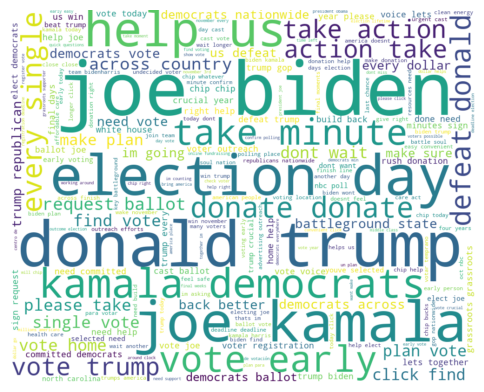

In [37]:
wordcloud_df = main_df.filter( (col("page_name").isin(["Joe Biden"])) & (month(col("file_date")) == 10)).select("ad_creative_body").toPandas()
text = " ".join([i for i in list(wordcloud_df["ad_creative_body"]) if i is not None])

tokens = re.sub(r"[^\w\s]", "", text)
tokens = tokens.lower()

stop_words = set(stopwords.words("english"))
filtered_tokens = [token for token in tokens.split(" ") if token not in stop_words]
final_text = " ".join(filtered_tokens)

wordcloud = WordCloud(width = 1000, height = 800, background_color = "white").generate(final_text)

plt.figure(figsize = (6,6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

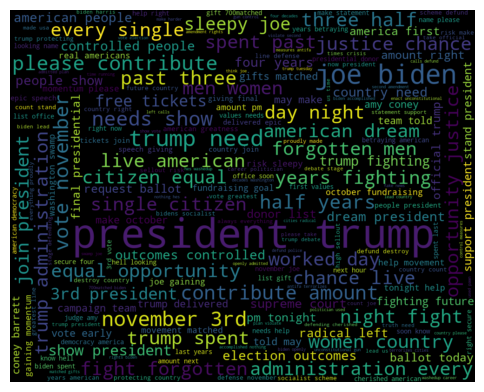

In [38]:
wordcloud_df = main_df.filter( (col("page_name").isin(["Donald J. Trump"])) & (month(col("file_date")) == 10)).select("ad_creative_body").toPandas()
text = " ".join([i for i in list(wordcloud_df["ad_creative_body"]) if i is not None])

tokens = re.sub(r"[^\w\s]", "", text)
tokens = tokens.lower()

stop_words = set(stopwords.words("english"))
filtered_tokens = [token for token in tokens.split(" ") if token not in stop_words]
final_text = " ".join(filtered_tokens)

wordcloud = WordCloud(width = 1000, height = 800, background_color = "black").generate(final_text)

plt.figure(figsize = (6,6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# Distributed Columns

In [39]:
distributed_df = main_df.select("ad_creation_time", "ad_delivery_start_time", "demographic_distribution", "funding_entity", "id", 
                        "page_name", "region_distribution", "spend_average", "impressions_average", "file_date")

In [40]:
region_df = distributed_df.select("ad_creation_time", "ad_delivery_start_time", "demographic_distribution",
                                    "funding_entity", "id", "page_name", "spend_average", "impressions_average",
                                    "file_date", explode("region_distribution").alias("region_distribution"))

region_df = region_df.withColumn("percentage", region_df.region_distribution.percentage) \
                                .withColumn("region", region_df.region_distribution.region) \
                                .withColumn("impression_percentage", (col("percentage") * col("impressions_average")).cast(IntegerType()) ) \
                                .withColumn("spend_percentage", (col("percentage") * col("spend_average")).cast(IntegerType()) ) \
                                .drop("distribution")

In [41]:
region_ad_df = region_df.groupBy("page_name", "id", "region").agg(avg("spend_percentage").alias("spend"), sum("impression_percentage").alias("impression_sum"))
region_ad_df = region_ad_df.groupBy("page_name", "region").agg(sum("spend").alias("spend_sum"), sum("impression_sum").alias("impression_sum"))
region_ad_df.toPandas().to_csv("region_impressions.csv", index = False)

In [42]:
demographic_df = distributed_df.select("ad_creation_time", "ad_delivery_start_time", "funding_entity", "id", "page_name", 
                                  "spend_average", "impressions_average", "file_date", 
                                  explode("demographic_distribution").alias("demographic_distribution"))

demographic_df = demographic_df.withColumn("percentage", demographic_df.demographic_distribution.percentage) \
                                .withColumn("age", demographic_df.demographic_distribution.age) \
                                .withColumn("gender", demographic_df.demographic_distribution.gender) \
                                .withColumn("impression_percentage", (col("percentage") * col("impressions_average")).cast(IntegerType()) ) \
                                .withColumn("spend_percentage", (col("percentage") * col("spend_average")).cast(IntegerType()) ) \
                                .drop("demographic_distribution")

In [43]:
gender_df = demographic_df.groupBy("page_name", "id", month("file_date").alias("month"), "gender").agg(avg("spend_percentage").alias("spend"), sum("impression_percentage").alias("impression_sum"))
gender_df = gender_df.groupBy("page_name", "month", "gender").agg(sum("spend").alias("spend"), sum("impression_sum").alias("impression_sum"))
gender_df = gender_df.toPandas()

gender_df = gender_df.sort_values(["page_name", "month", "gender"])
gender_df.to_csv("gender.csv", index = False)

In [44]:
age_df = demographic_df.groupBy("page_name", "id", month("file_date").alias("month"), "age").agg(avg("spend_percentage").alias("spend"), sum("impression_percentage").alias("impression_sum"))
age_df = age_df.groupBy("page_name", "month", "age").agg(sum("spend").alias("spend"), sum("impression_sum").alias("impression_sum"))
age_df = age_df.toPandas()

age_df = age_df.sort_values(["page_name", "month", "age"])
age_df.to_csv("age.csv", index = False)

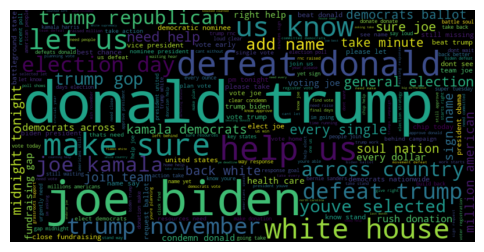

In [45]:
wordcloud_df = main_df.filter( (col("page_name").isin(["Joe Biden"])) ).select("ad_creative_body").toPandas()
text = " ".join([i for i in list(wordcloud_df["ad_creative_body"]) if i is not None])

tokens = re.sub(r"[^\w\s]", "", text)

stop_words = set(stopwords.words("english"))
filtered_tokens = [token for token in tokens.split() if token.lower() not in stop_words]
final_text = " ".join(filtered_tokens)
final_text = final_text.lower()

wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate(final_text)

plt.figure(figsize = (6,6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

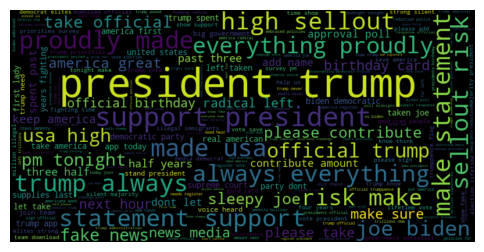

In [46]:
wordcloud_df = main_df.filter( (col("page_name").isin(["Donald J. Trump"])) & (month(col("file_date")) <= 9) ).select("ad_creative_body").toPandas()
text = " ".join([i for i in list(wordcloud_df["ad_creative_body"]) if i is not None])

tokens = re.sub(r"[^\w\s]", "", text)

stop_words = set(stopwords.words("english"))
filtered_tokens = [token for token in tokens.split() if token.lower() not in stop_words]
final_text = " ".join(filtered_tokens)
final_text = final_text.lower()

wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate(final_text)

plt.figure(figsize = (6,6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [47]:
data = {
    'State': ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
    'Winner': ['Donald J. Trump', 'Donald J. Trump', 'Joe Biden', 'Donald J. Trump', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Donald J. Trump', 'Joe Biden', 'Joe Biden', 'Donald J. Trump', 'Joe Biden', 'Donald J. Trump', 'Donald J. Trump', 'Donald J. Trump', 'Donald J. Trump', 'Donald J. Trump', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Donald J. Trump', 'Donald J. Trump', 'Donald J. Trump', 'Donald J. Trump', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Donald J. Trump', 'Donald J. Trump', 'Joe Biden', 'Donald J. Trump', 'Donald J. Trump', 'Joe Biden', 'Joe Biden', 'Donald J. Trump', 'Donald J. Trump', 'Donald J. Trump', 'Donald J. Trump', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Joe Biden', 'Donald J. Trump', 'Donald J. Trump', 'Joe Biden']
}

df = pd.DataFrame(data)

df.to_csv("winner.csv", index = False)